In [1]:
import numpy 
import yaml
import os
import glob
import sys
import random
import seaborn 
import umap
import ipywidgets

from matplotlib import pyplot, gridspec, colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage import io
from PIL import Image, ImageDraw

from banditopt import algorithms

# Defines constants used across notebook
PATH = "../../data"
REGRESSORS_DICT = {
    "sklearn_BayesRidge":algorithms.sklearn_BayesRidge,
    "sklearn_GP":algorithms.sklearn_GP,
}
OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 0.,
        "max" : 200,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 0.1,
    },
    "Squirrel" : {
        "min" : 0.,
        "max" : 40.,
    }
}

Could not load microscope interface. Some functions may not be available.
Pygmo is not installed


In [6]:
def scale_obj(y, obj_name):
    """
    Scales the objectives using the scaling function
    
    :param y: A `numpy.ndarray` of the objective value
    :param obj_name: A `str` of the objective name
    """
    return (y - CONFIG["obj_normalization"][obj_name]["min"]) / (CONFIG["obj_normalization"][obj_name]["max"] - CONFIG["obj_normalization"][obj_name]["min"])

def scale_param(X, param_name):
    """
    Scales the parameters using the scaling function
    
    :param X: A `numpy.ndarray` of the parameters
    :param param_name: A `str` of the parameter
    
    :return : A `numpy.ndarray` of the parameters
    """
    m = CONFIG["x_mins"][CONFIG["param_names"].index(param_name)]
    M = CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)]
    return (X - m) / (M - m)

def rescale_obj(y, obj_name):
    """
    Rescales the objectives using the scaling function
    
    :param y: A `numpy.ndarray` of the objective value
    :param obj_name: A `str` of the objective name
    """
    return y * (CONFIG["obj_normalization"][obj_name]["max"] - CONFIG["obj_normalization"][obj_name]["min"]) + CONFIG["obj_normalization"][obj_name]["min"]

def rescale_param(X, param_name):
    """
    Scales the parameters using the scaling function
    
    :param X: A `numpy.ndarray` of the parameters
    :param param_name: A `str` of the parameter
    
    :return : A `numpy.ndarray` of the parameters
    """
    m = CONFIG["x_mins"][CONFIG["param_names"].index(param_name)]
    M = CONFIG["x_maxs"][CONFIG["param_names"].index(param_name)]
    return X * (M - m) + m

def load_data(path, trial=0, scale=False):
    """
    Loads the data from the given path
    
    :param path: A `str` of the path
    :param trial: An `int` of the number of path
    
    :returns : A `dict` of the X
               A `dict` of the y
    """ 
    X = numpy.loadtxt(os.path.join(path, f"X_{trial}.csv"), delimiter=",")
    y = numpy.loadtxt(os.path.join(path, f"y_{trial}.csv"), delimiter=",")
    if X.ndim == 1:
        X = X[:, numpy.newaxis]
    X = {
        param_name : scale_param(X[:, sum(NDIMS[:i]) : sum(NDIMS[:i]) + NDIMS[i]], param_name) 
                     if scale else X[:, sum(NDIMS[:i]) : sum(NDIMS[:i]) + NDIMS[i]]
        for i, param_name in enumerate(CONFIG["param_names"])
    }
    y = {
        obj_name : rescale_obj(y[:, i], obj_name)
        for i, obj_name in enumerate(CONFIG["obj_names"])
    }
    return X, y

def load_config(path):
    """
    Loads the configuration file from the given path
    """
    config = yaml.load(open(os.path.join(path, "config.yml"), "r"), Loader=yaml.Loader)
    ndims, param_space_bounds, param_names = [], [], []
    for i, param_name in enumerate(config["param_names"]):
        if param_name in ["decision_time", "threshold_count"]:
            ndims.append(2)
        else:
            ndims.append(1)
        param_space_bounds.extend([[config["x_mins"][i], config["x_maxs"][i]]] * ndims[-1])            
        param_names.extend([param_name] * ndims[-1])
    n_points = [config["n_divs_default"]]*sum(ndims)  
    return config, ndims, param_space_bounds, param_names, n_points

def load_images(path, trial="0", image_type="sted"):
    """
    Loads the complete list of acquired images
    """
    image_names = glob.glob(os.path.join(path, image_type, trial, "*.tif"))
    return list(sorted(image_names, key = lambda name : int(os.path.basename(name).split(".")[0])))

class ImageLoader():
    def __init__(self, image_names, max_cache_size=100):
        self.image_names = image_names
        self.cache = {}
        self.max_cache_size = max_cache_size
        
    def __getitem__(self, index):
        """
        Implements a `__getitem__`
        
        :param index: An `int` of the index
        
        :returns : A `numpy.ndarray` of the image
        """
        if str(index) not in self.cache:
            im = io.imread(self.image_names[index])
            self._add_cache(index, im)
        return self.cache[str(index)]
    
    def _add_cache(self, index, item):
        """
        Adds an item to cache
        
        :param index: An index
        :param item: The item to add in the cache
        """
        if len(self.cache) > self.max_cache_size:
            keys = list(self.cache.keys())
            del self.cache[keys[0]]
        self.cache[str(index)] = item
        
def create_figax(y, sharex=True):
    """
    Creates a `matplotlib.Figure` with a specific gridspec
    """
    fig = pyplot.figure(figsize=(9,6))
    gs = gridspec.GridSpec(nrows=len(y), ncols=4, width_ratios=[3, 1, 1, 1])
    axes = numpy.array([
        fig.add_subplot(gs[:, 0]),
        *[fig.add_subplot(gs[i, 1]) for i in range(len(y))],
        *[fig.add_subplot(gs[j, i + 2]) for j in range(len(y)) for i in range(2) ]
    ])
    axes[0].get_shared_x_axes().join(*axes)
    axes[0].get_shared_y_axes().join(*axes)    

    for ax in axes:
        ax.set_xticklabels([])
        ax.set_yticklabels([])    
    return fig, {"main" : axes[0], "obj" : axes[1:4], "param" : axes[4:]}
        
def plot_umap_points(X, y, image_loader, obj_name=None, X_transformed=None):
    """
    Plots a multidimensional umap analysis

    :param X: A `dict` of parameters
    :param y: A `dict` of objectives

    :returns : A `umap.UMAP` trained
               A `numpy.ndarray` of the transformed data
    """
    # Combines all data
    all_data = numpy.concatenate((
            numpy.concatenate([scale_param(X[param_name], param_name) for param_name in CONFIG["param_names"]], axis=1),
            numpy.concatenate([scale_obj(y[obj_name][:, numpy.newaxis], obj_name) for obj_name in CONFIG["obj_names"]], axis=-1)
        ),
        axis=-1
    )

    # Creates the mapper
    random.seed(42)
    numpy.random.seed(42)
    mapper = umap.UMAP(n_neighbors=15, min_dist=1., random_state=42).fit(all_data)
    X_transformed = mapper.transform(all_data)

    fig, axes = create_figax(y)
    axes["main"].scatter(
        *X_transformed.T, alpha=1., linewidth=1, edgecolor="black", color="black", s=50
    )
    for ax, (obj_name, values) in zip(axes["obj"].ravel(), y.items()):
        sc = ax.scatter(
            *X_transformed.T, c=values, alpha=1., cmap="magma", linewidth=1, edgecolor="black",
            vmin=OBJ_PLOT_LIM[obj_name]["min"], vmax=OBJ_PLOT_LIM[obj_name]["max"], s=25
        )
        ax.set(
            title = obj_name,
    #             xlim=(X_transformed.min(axis=0)[0], X_transformed.max(axis=0)[0]),
    #             ylim=(X_transformed.min(axis=0)[1], X_transformed.max(axis=0)[1])
        )
        fig.colorbar(sc, ax=ax)
    
    for ax, param_name, values, bounds in zip(axes["param"].ravel(), PARAM_NAMES, all_data.T[:-3], PARAM_SPACE_BOUNDS):
        sc = ax.scatter(
            *X_transformed.T, c=rescale_param(values, param_name), alpha=1., cmap="magma", linewidth=1, edgecolor="black",
            vmin=bounds[0], vmax=bounds[1], s=25
        )
        ax.set(
            title = param_name,
    #             xlim=(X_transformed.min(axis=0)[0], X_transformed.max(axis=0)[0]),
    #             ylim=(X_transformed.min(axis=0)[1], X_transformed.max(axis=0)[1])
        )
        fig.colorbar(sc, ax=ax)        
    return mapper, X_transformed, fig, axes

<IPython.core.display.Javascript object>


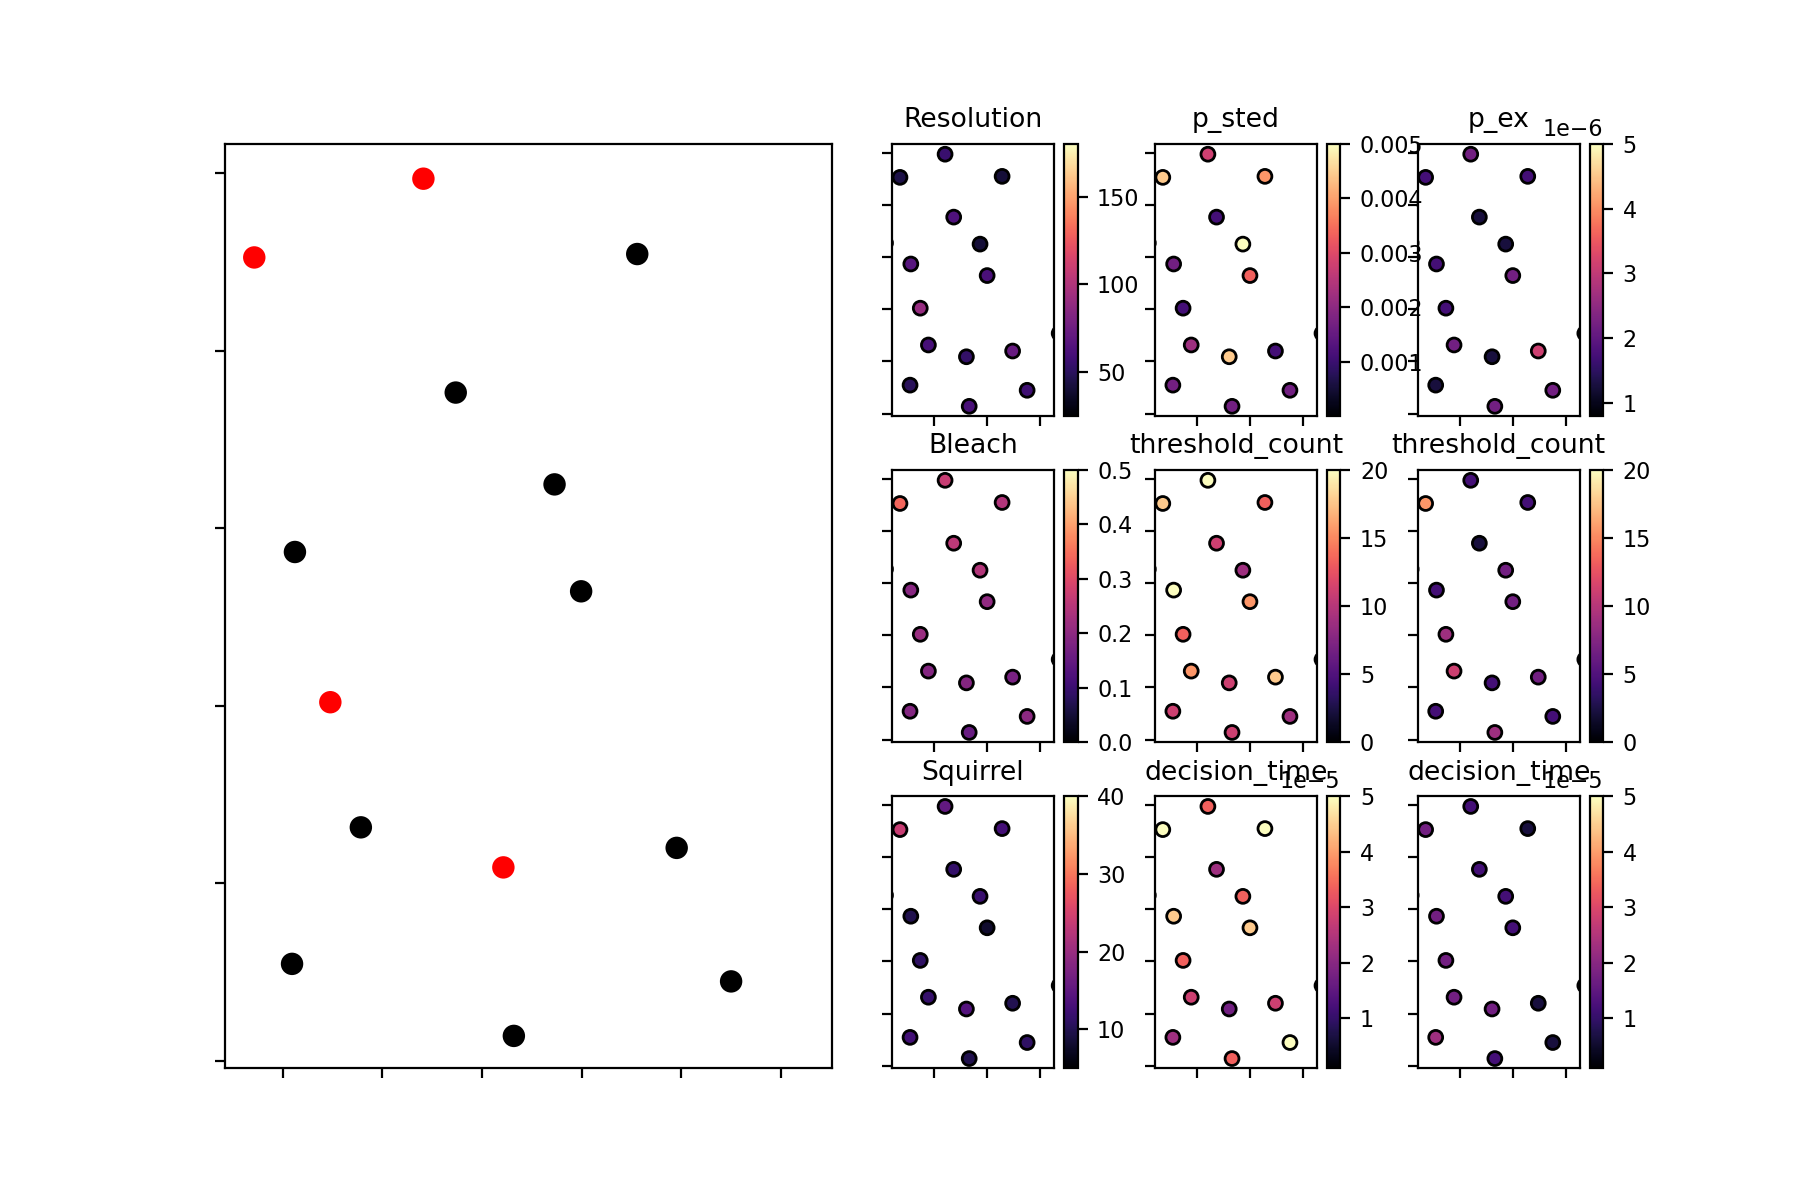

FloatSlider(value=180.0, description='Resolution', max=180.0, min=25.0, step=1.55)

FloatSlider(value=0.5, description='Bleach', max=0.5, step=0.005)

FloatSlider(value=40.0, description='Squirrel', max=40.0, min=5.0, step=0.35)

In [11]:
%matplotlib notebook
import matplotlib
matplotlib.rcParams["font.size"] = 8

model_names = [
    "20210709-095658_DyMIN_prefnet_6params_3objectives_degree4",
]

OBJ_PLOT_LIM = {
    "Resolution" : {
        "min" : 25.,
        "max" : 180.,
    },
    "SNR" : {
        "min" : 0.,
        "max" : 4.,
    },
    "Bleach" : {
        "min" : 0.,
        "max" : 0.5,
    },
    "Squirrel" : {
        "min" : 5.,
        "max" : 40.,
    }
}

# for model_name in model_names:
model_name = model_names[0]
CONFIG, NDIMS, PARAM_SPACE_BOUNDS, PARAM_NAMES, N_POINTS = load_config(os.path.join(PATH, model_name))
X, y = load_data(os.path.join(PATH, model_name))
image_names = load_images(os.path.join(PATH, model_name))
image_loader = ImageLoader(image_names)

mapper, X_transformed, fig, axes = plot_umap_points(X, y, image_loader, "Resolution")

# Creates the annotation box
norm = colors.Normalize(vmin=0, vmax=250)
im = OffsetImage(image_loader[1], zoom=2, cmap="hot", norm=norm)
ab = AnnotationBbox(
    im, (0, 0), xybox=(50, 50), xycoords='data',
    boxcoords="offset points",  frameon=False
)

# add it to the axes and make it invisible
axes["main"].add_artist(ab)
ab.set_visible(False)

def hover(event):

    update_points_color()
    # Gets scatter points from ax
    sc = axes["main"].collections[0]    
    
    contains, index = sc.contains(event)
    if contains:
        # May have multiple points in array
        index = index["ind"][0]
        # Sets the new position
        ab.xy = (X_transformed[index])

        sizes = numpy.ones(len(X_transformed)) * 50
        sizes[index] = 200
        sc.set_sizes(sizes)
        
        sizes = numpy.ones(len(X_transformed)) * 25
        sizes[index] = 200
        # Changes size of other axes
        for ax in axes["obj"]:
            sc = ax.collections[0]
            sc.set_sizes(sizes)
        for ax in axes["param"]:
            sc = ax.collections[0]
            sc.set_sizes(sizes)            

        im.set_data(image_loader[index])
        ab.set_visible(True)
    else:
        sizes = numpy.ones(len(X_transformed)) * 50
        sc.set_sizes(sizes)        
        sizes = numpy.ones(len(X_transformed)) * 25
        # Changes size of other axes
        for ax in axes["obj"]:
            sc = ax.collections[0]
            sc.set_sizes(sizes)
        for ax in axes["param"]:
            sc = ax.collections[0]
            sc.set_sizes(sizes)            

        ab.set_visible(False)
    fig.canvas.draw_idle()

def update_points_color():
    # Gets scatter points from ax
    sc = axes["main"].collections[0]    
    # updates the colors of the points according to the slider
    cols = numpy.ones(len(X_transformed), dtype=bool)
    for obj_name, values in y.items():
        slider = sliders[obj_name]
        cols =  cols * (values < (float(slider.value)))
    cols = ["black" if c else "red" for c in cols]
    sc.set_color(cols)
    fig.canvas.draw_idle()

sliders = {
    obj_name : ipywidgets.FloatSlider(
        description=obj_name,
        value=OBJ_PLOT_LIM[obj_name]["max"],
        min=OBJ_PLOT_LIM[obj_name]["min"], max=OBJ_PLOT_LIM[obj_name]["max"],
        step=(OBJ_PLOT_LIM[obj_name]["max"]-OBJ_PLOT_LIM[obj_name]["min"]) / 100
    ) 
    for obj_name, values in y.items()
}
def slider_changed(event):
    update_points_color()
    
for slider in sliders.values():
    slider.observe(slider_changed)
    display(slider)

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)
pyplot.show(block=True)